# Tesing multi group permutation

In the case of dependencies between observations during a 2 sample test, we hold fixed their relative labels during the permutation. 

Here, we simulate pairs of observations more similar to one another than others. We form two sets of labels in the two sample test. In the "null" case, we are pair agnostic. Otherwise, either the pairs are assigned:
- the same label (differences **across**)
- different labels (differences **within**)

Followng the simulations, the scipy permutation code is validated and we see that the permutations sort pairs correctly while the "null" permutation case shows no pattern.

In [22]:
import sys, os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

sys.path.append(os.path.realpath('..'))
from hyppo.independence import MGC
from scipy.stats import multiscale_graphcorr
from scipy.spatial.distance import squareform, pdist
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
n = 100
m = 2
d = 4
mus = np.random.normal(0,1,(n,d))
X = np.vstack(
    [np.random.normal(mu,0.1,(m,d)) for mu in mus]
)
Y_within = np.hstack([[0,1] for _ in range(n)])
Y_across = np.hstack(
    [[0] for _ in range(n)] +
    [[1] for _ in range(n)]
)
groups = np.hstack(
    [[f'{i}']*m for i in range(n)]
)

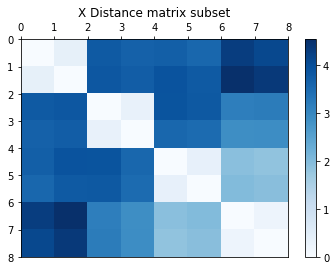

In [54]:
#data = squareform(pdist(Y_within[:8,None]))
data = squareform(pdist(X[:8]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('X Distance matrix subset')
plt.show()

### Across classes

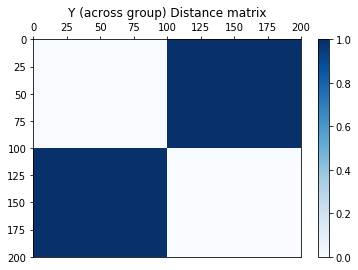

In [60]:
data = squareform(pdist(Y_across[:,None]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('Y (across group) Distance matrix')
plt.show()

In [47]:
stat_uc, pval_uc, mgc_dict_uc = multiscale_graphcorr(
    X,Y_across,
    reps=1000,
    workers=10,
    random_state=1,
    permute_groups=np.arange(Y_across.shape[0])
)

In [48]:
print(f'Unconditioned Permutations: {pval_uc}')
print(f'Optimal Scale {mgc_dict_uc["opt_scale"]}')

Unconditioned Permutations: 0.001
Optimal Scale [3, 1]


In [49]:
stat_c, pval_c, mgc_dict_c = multiscale_graphcorr(
    X,Y_across,
    reps=1000,
    workers=10,
    random_state=1,
    permute_groups=groups
)

In [50]:
print(f'Conditioned Permutations: {pval_c}')
print(f'Optimal Scale {mgc_dict_c["opt_scale"]}')

Conditioned Permutations: 0.11
Optimal Scale [3, 1]


### Within class

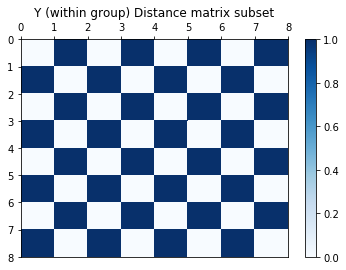

In [56]:
data = squareform(pdist(Y_within[:8,None]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('Y (within group) Distance matrix subset')
plt.show()

In [51]:
stat_uc, pval_uc, mgc_dict_uc = multiscale_graphcorr(
    X,Y_within,
    reps=1000,
    workers=10,
    random_state=1,
    permute_groups=np.arange(Y_within.shape[0])
)
print(f'Unconditioned Permutations: {pval_uc}')
print(f'Optimal Scale {mgc_dict_uc["opt_scale"]}')

Unconditioned Permutations: 1.0
Optimal Scale [200, 2]


In [52]:
stat_c, pval_c, mgc_dict_c = multiscale_graphcorr(
    X,Y_within,
    reps=1000,
    workers=10,
    random_state=1,
    permute_groups=groups
)
print(f'Conditioned Permutations: {pval_c}')
print(f'Optimal Scale {mgc_dict_c["opt_scale"]}')

Conditioned Permutations: 0.01
Optimal Scale [200, 2]


## Test Scipy Code

In [68]:
from collections import defaultdict
from copy import deepcopy

In [62]:
class _ParallelP(object):
    """
    Helper function to calculate parallel p-value.
    """
    def __init__(self, x, y, random_states, permute_groups=None):
        self.x = x
        self.y = y
        self.random_states = random_states
        self.permute_groups = permute_groups
        if permute_groups is not None:
            # Get labels, as we assume a two sample test
            self.y_labels = np.unique(y, return_inverse=True, axis=1)[1]
            # dict: [y_label] -> list(indices)
            self.class_indices = defaultdict(list) 
            # dict: [group_label] -> list(indices)
            group_indices = defaultdict(lambda: defaultdict(list))
            for i,(group,label) in enumerate(zip(permute_groups, self.y_labels)):
                self.class_indices[label].append(i)
                group_indices[group][label].append(i)
            # list of group indices, sorted descending order
            self.group_indices = sorted(
                group_indices.values(), key=lambda x: max([len(d) for d in x.values()]), reverse=True
            )
            #self.min_group_size = len(self.group_indices[-1])

    def __call__(self, index):
        if self.permute_groups is None:
            order = self.random_states[index].permutation(self.y.shape[0])
        else:
            # Copy dict: [y_label] -> list(indices)
            class_indices_copy = deepcopy(self.class_indices)
            new_indices = []
            old_indices = []
            min_reamining = np.cumsum(
                [min([len(d) for d in x.values()]) for x in self.group_indices]
            )[::-1]
            # For each list(group_indices)
            for group,min_r in zip(self.group_indices, min_reamining):
                p1 = self.factorial(len(class_indices_copy[0]), len(group[0])) * \
                     self.factorial(len(class_indices_copy[1]), len(group[1]))
                p2 = self.factorial(len(class_indices_copy[1]), len(group[0])) * \
                     self.factorial(len(class_indices_copy[0]), len(group[1]))
                if np.random.uniform() < p1 / (p1+p2):
                    # Assign groups[0] idxs to class 0 and vice versa
                    new_indices += [class_indices_copy[0].pop() for _ in range(len(group[0]))]
                    new_indices += [class_indices_copy[1].pop() for _ in range(len(group[1]))]
                else:
                    new_indices += [class_indices_copy[1].pop() for _ in range(len(group[0]))]
                    new_indices += [class_indices_copy[0].pop() for _ in range(len(group[1]))]
                # Old indices in correct order
                old_indices += group[0]
                old_indices += group[1]
            order = np.ones(self.y.shape[0]) * -1
            order[np.asarray(old_indices)] = new_indices
            order = order.astype(int)
        permy = self.y[order]#[:, order]

        # calculate permuted stats, store in null distribution
        # perm_stat = _mgc_stat(self.x, permy)[0]

        return permy

    def factorial(self, n, n_mults):
        if n_mults == 0:
            return 1
        else:
            return n * self.factorial(n-1, n_mults-1)

### Within Y

#### No Grouping

In [66]:
p = _ParallelP(
    None,
    squareform(pdist(Y_within[:,None])),
    None,
    permute_groups=np.arange(Y_within.shape[0])
)
y_perm = p(None)

In [85]:
(y_perm[::2] * y_perm[1::2]).sum(axis=1)

array([  0., 100., 100.,   0.,   0.,   0.,   0., 100., 100., 100., 100.,
         0.,   0., 100., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.,
       100.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       100.,   0., 100., 100.,   0.,   0.,   0.,   0., 100., 100.,   0.,
         0.,   0.,   0., 100.,   0., 100.,   0., 100.,   0.,   0., 100.,
       100.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0., 100., 100.,
         0., 100.,   0., 100.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
         0., 100.,   0., 100., 100., 100.,   0.,   0.,   0.,   0., 100.,
         0.])

#### With Grouping

In [86]:
p = _ParallelP(
    None,
    squareform(pdist(Y_within[:,None])),
    None,
    permute_groups=groups
)
y_perm = p(None)

In [87]:
(y_perm[::2] * y_perm[1::2]).sum(axis=1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Between Y

#### No Grouping

In [89]:
p = _ParallelP(
    None,
    squareform(pdist(Y_across[:,None])),
    None,
    permute_groups=np.arange(Y_within.shape[0])
)
y_perm = p(None)

In [90]:
(y_perm[::2] * y_perm[1::2]).sum(axis=1)

array([100.,   0., 100.,   0.,   0.,   0.,   0., 100., 100., 100.,   0.,
       100.,   0.,   0.,   0.,   0.,   0., 100., 100.,   0., 100.,   0.,
       100., 100.,   0., 100.,   0.,   0., 100.,   0., 100.,   0.,   0.,
         0.,   0.,   0., 100.,   0.,   0., 100.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 100., 100.,   0., 100., 100., 100.,   0.,
         0., 100., 100., 100.,   0.,   0., 100., 100., 100., 100.,   0.,
       100., 100., 100.,   0., 100., 100.,   0.,   0., 100., 100.,   0.,
         0.,   0.,   0., 100., 100.,   0.,   0.,   0., 100., 100.,   0.,
       100., 100., 100.,   0.,   0.,   0.,   0., 100.,   0., 100.,   0.,
         0.])

#### With Grouping

In [91]:
p = _ParallelP(
    None,
    squareform(pdist(Y_across[:,None])),
    None,
    permute_groups=groups
)
y_perm = p(None)

In [92]:
(y_perm[::2] * y_perm[1::2]).sum(axis=1)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.])